In [1]:
from hossam import load_data
from pandas import DataFrame, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

#로지스틱을 위한 참조
import statsmodels.api as sm

#로지스틱의 결과 판별을 위한 참조
# -> 머신러닝 라이브러리를 미리 사용함
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score,precision_score, f1_score

In [2]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [3]:
origin = load_data('graduate')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab12_/graduate.xlsx
[desc] 방사선학 석사과정 대학원생 모집 현황을 조사한 가상의 데이터
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (400, 4)
열 개수: 4
행 개수: 400

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   합격여부    400 non-null    int64  
 1   필기점수    400 non-null    int64  
 2   학부성적    400 non-null    float64
 3   병원경력    400 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 12.6+ KB
None


,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,1~5년
1,1,660,3.67,1~5년
2,1,800,4.00,10년 이상
3,1,640,3.19,1년 미만
4,0,520,2.93,1년 미만


# 데이터 전처리
병원경력의 종류 확인

In [4]:
origin['병원경력'].unique()

array(['1~5년', '10년 이상', '1년 미만', '5~10년'], dtype=object)

명목형 변수의 전처리

In [5]:
df= origin.copy()
df['병원경력'] = df['병원경력'].map({
    '1년 미만':0, '1~5년':1, '5~10년':2, '10년 이상':3

})

df['병원경력'].unique()

array([1, 3, 0, 2])

명목형 변수의 더미변수 처리(One-Hot Encoding)

In [6]:
df2 = get_dummies(df, columns=['병원경력'], dtype='int', drop_first=True)
df2.head()

,합격여부,필기점수,학부성적,병원경력_1,병원경력_2,병원경력_3
0,0,380,3.61,1,0,0
1,1,660,3.67,1,0,0
2,1,800,4.00,0,0,1
3,1,640,3.19,0,0,0
4,0,520,2.93,0,0,0


# 로지스틱 회귀 분석

In [7]:
yname = '합격여부'              # 종속변수 이름

x = df2.drop(yname, axis=1)    # 독립변수만 추출(DataFrame 형태)
y = df2[yname]                 #종속변수만 추출(Series 형태)

x_input = sm.add_constant(x)   #독립변수에 상수항 추가
display(x_input)

fit = sm.Logit(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

,const,필기점수,학부성적,병원경력_1,병원경력_2,병원경력_3
0,1.0,380,3.61,1,0,0
1,1.0,660,3.67,1,0,0
2,1.0,800,4.00,0,0,1
3,1.0,640,3.19,0,0,0
4,1.0,520,2.93,0,0,0
...,...,...,...,...,...,...
395,1.0,620,4.00,0,1,0
396,1.0,560,3.04,1,0,0
397,1.0,460,2.63,0,1,0
398,1.0,700,3.65,0,1,0


Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   합격여부   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Mon, 12 Jan 2026   Pseudo R-squ.:                 0.08292
Time:                        19:28:05   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5414      1.138     -4.869      0.000      -7.772      -3.311
필기점수           0.0023      0.

# 이진분류의 평가
혼동행렬 구하기

실제 종속변수

In [8]:
y_true = df2['합격여부']
y_true

0      0
1      1
2      1
3      1
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 합격여부, Length: 400, dtype: int64

로지스틱이 예측한 값

In [9]:
y_pred = fit.predict(x_input)
y_pred

0      0.172627
1      0.292175
2      0.738408
3      0.178385
4      0.118354
         ...   
395    0.488670
396    0.165504
397    0.181062
398    0.463667
399    0.300731
Length: 400, dtype: float64

혼동행렬 구하기 위해 예측 결과를 이진값으로 변환(50프로 초과인 경우 True, 그렇지 않을 경우 False로 변환)

In [10]:
y_pred_fix = y_pred>0.5
y_pred_fix

0      False
1      False
2       True
3      False
4      False
       ...  
395    False
396    False
397    False
398    False
399    False
Length: 400, dtype: bool

혼동행렬

In [11]:
cm  = confusion_matrix(y_true, y_pred_fix)
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(np.int64(254), np.int64(19), np.int64(97), np.int64(30))

혼동행렬을 DataFrame으로 변환

In [12]:
cmdf = DataFrame(cm, index=['Actual 0 (TN/FP)', 'Actual 1 (FN/TP)'], columns=['PREDICTED (Negitive)', 'Predicted(Positive)'])
cmdf

,PREDICTED (Negitive),Predicted(Positive)
Actual 0 (TN/FP),254,19
Actual 1 (FN/TP),97,30


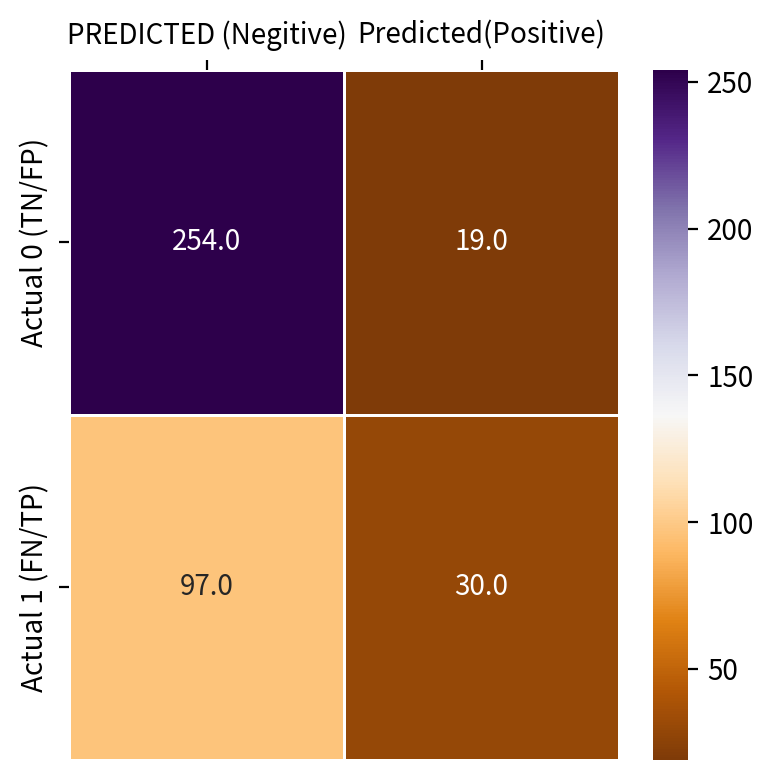

In [13]:
#혼동행렬 히트맵
width_px =800
height_px = 800
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.heatmap(data=cmdf, annot=True, fmt="0.1f", linewidth=0.5, cmap='PuOr')


ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()         #x축의 변수 이름을 상단으로 이동


plt.tight_layout()
plt.show()
plt.close()

# 정확도
전체 데이터(FP+FN+TP+TN)중에서 제대로 판정한 데이터(TP+TN)의 비율

$$Acuuracy = \frac{정확히~예측한~데이터~수}{전체~데이터~수} = \frac{TN+TP}{TN+FP+FN+TP}$$

In [14]:
(tn+tp)/(tn+fp+fn+tp)

np.float64(0.71)

In [15]:
acc = accuracy_score(y_true, y_pred_fix)
acc

0.71

# 정밀도
양성으로 예측한 데이터 중에서 관측치도 양성으로 예측한 비율
TPR(True Positive Rate ) 또는 민감도(sensitivity)라고도 한다.
$$TPR = \frac{실제~Positive중~Positive로~맞춘~개수}{실제~Positive~전체~개수} = \frac{TP}{TP+FN}$$

In [16]:
#pre = tp/(fp+tp)
pre = precision_score(y_true, y_pred_fix)
pre


0.6122448979591837

# 재현율
실제로 양성인 관측치중에서 양성으로 예측한 비율
TPR(True Positive Rate) 또는 민감도(sensitivity)라고도 한다.
$$TPR = \frac{실제~Positive중~Positive로~맞춘~개수}{실제~Positive~전체~개수} = \frac{TP}{TP+FN}$$

In [17]:
recall = tp/(tp+fn)
recall = recall_score(y_true, y_pred_fix)
recall

0.23622047244094488

위양성을, 거짓 양성비율(Fallout, FPR)
실제로는 음성인 관측치 중에서 양성으로 예측한 비율
FPR(False Positive Rate)이라고도 한다.
$$FPR = \frac{Negative를~Positive로~잘못~예측한~개수}{실제값이~Negative~인것들}=\frac{FP}{fp+tn}$$
함수 지원x

In [18]:
fpr = fp/(fp+tn)
fpr

np.float64(0.0695970695970696)

# 특이성(Specificity, TNR, True Negative Rate)
1에서 위양성률의 값을 뺀값으로 실제 값 Negative가 정확히 예측되어야 하는 수준을 의미한다.
$$TNR = 1-FPR = \frac{Negative로~올바르게~예측한~개수}{실제값이~Negative~인것들} = \frac{TN}{TN+FP}$$

In [19]:
#함수지원X
tnr = 1-fpr
tnr

np.float64(0.9304029304029304)

# F1 Store
Precision 과 Recall의 조화평균
정밀도(Precision)와 재현율(Recall)을 결합한 지표이다.
정밀도(Precision)와 재현율(Recall)이 어느 한 쪽으로 치우치지 않을 때 상대적으로 높은 값을 가진다.
TN은 상관없다.
$$F1 = 2\times\frac{Precision\times Recall}{Precision + Recall} = \frac{2TP}{2TP+FP+FN}$$


In [20]:
#f1 = 2*((pre*recall)/(pre*recall))
f1 = f1_score(y_true, y_pred_fix)
f1

0.3409090909090909

# ROC Curve
재현율과 위양성률은 일반적으로 양의 상관 관계가 있다.
ROC Curve는 클래스 판별 기준값의 변화에 따른 위양성률과 재현율의 변화를 시가고하한 것이다.
재현율을 y축으로, 위양성률을 x축으로 잡은 그래프


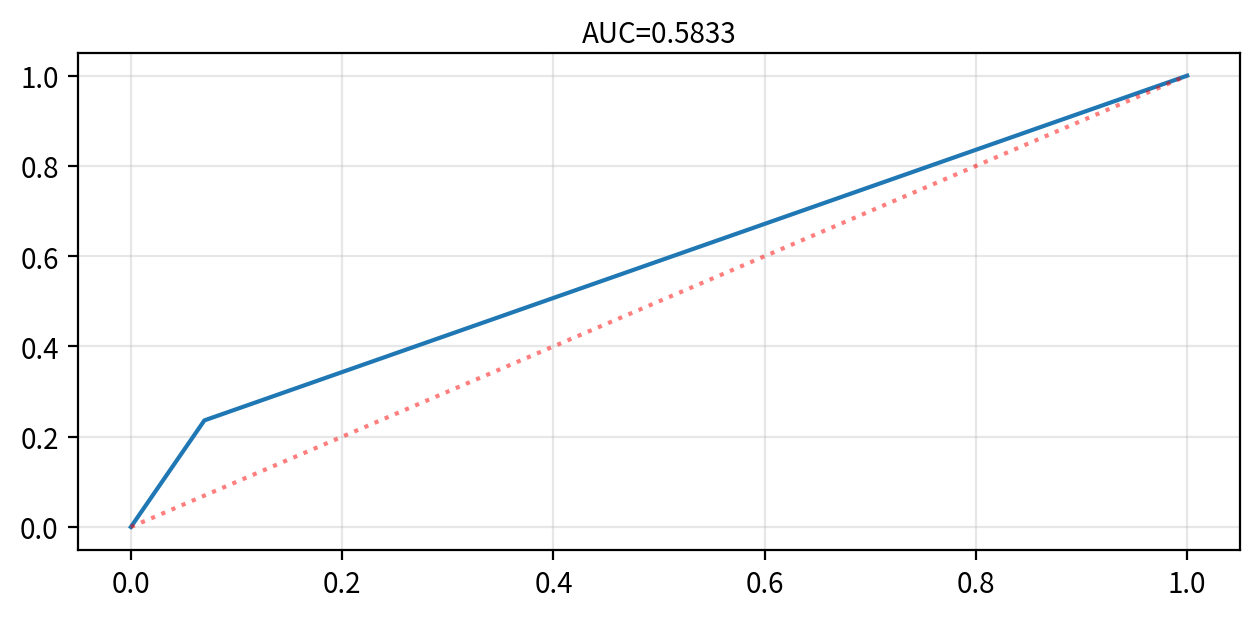

In [21]:
ras = roc_auc_score(y_true, y_pred_fix)

roc_fpr, roc_tpr, thresholds = roc_curve(y_true, y_pred_fix)

width_px = 1280
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.lineplot( x=roc_fpr,y=roc_tpr)
sb.lineplot( x=[0,1],y=[0,1], color ='red', linestyle=":", alpha=0.5)

ax.grid(True, alpha=0.3)
ax.set_title(f"AUC={ras:.4f}", fontsize=10, pad=4)




plt.tight_layout()
plt.show()
plt.close()

가운데 직선은 ROC 곡선의 최저값으로, ROC Curve가 가운데 직선에 가까울수록 성능이 떨어지는 것이며, 멀어질수록 성능이 뛰어난 것이다.
ROC Curve는 FPR을 0부터 1까지 변화시키면서 TPR의 변화값을 구한다.



# AUC(Area Under Curve)

ROC 곡선 밑의 면적을 구한 것으로, 1에 가까울수록 좋은 수치이다.
가운데 직선에서 멀어지고, 왼쪽 상단 모서리쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이 되어 면적이 1에 가까워진다.

In [22]:
result_df = DataFrame({
    '설명력':[fit.prsquared],
    '정확도':[acc],
    '정밀도':[pre],
    '재현율':[recall],
    '위양성율':[fpr],
    '특이성':[tnr],
    'RAS':[ras],
    'f1_score':[f1]
})
result_df

,설명력,정확도,정밀도,재현율,위양성율,특이성,RAS,f1_score
0,0.082922,0.71,0.612245,0.23622,0.069597,0.930403,0.583312,0.340909


# Odds Ratio(오즈비 또는 승산비)

임의의 이벤트가 어떤 요인에 의해 발생하지 않을 확률 대비 발생할 확률
로지스틱 회귀분석에서 임의의 설명변수의 추이에 따른 목표변수의 추이를 표현할 때 주로 사용되는 것
$$Odds = \frac{이벤트~발생~확률}{이벤트~미발생~확률} = \frac{p}{1-p}$$

In [23]:
coef = fit.params
coef

const    -5.541443
필기점수      0.002264
학부성적      0.804038
병원경력_1    0.211260
병원경력_2    0.876021
병원경력_3    1.551464
dtype: float64

In [24]:
odds_rate = np.exp(coef)
odds_rate_df = DataFrame(odds_rate, columns=['odds_rate'])
odds_rate_df

,odds_rate
const,0.003921
필기점수,1.002267
학부성적,2.234545
병원경력_1,1.235233
병원경력_2,2.401325
병원경력_3,4.718371


In [25]:
odds_ratio=(tp*tn)/(fp*fn)
odds_ratio

np.float64(4.134563212154097)

In [26]:
myinput = "480, 4.3, 0,0,1"
myinput=myinput.split(',')

x_new = DataFrame([{'필기점수': int(myinput[0].strip()),
                    '학부성적':float(myinput[1].strip()),
                    '병원경력_1':int(myinput[2].strip()),
                    '병원경력_2':int(myinput[3].strip()),
                    '병원경력_3':int(myinput[4].strip())}])

x_new_input = sm.add_constant(x_new, has_constant='add')

myresult = fit.predict(x_new_input)
myresult    

0    0.635134
dtype: float64

In [27]:
"당신의 합격 확률은 {0:0.2f}% 입니다.".format(myresult[0]*100)

'당신의 합격 확률은 63.51% 입니다.'

In [28]:
"합격"if myresult[0]>0.5 else "불합격"

'합격'